# [E-09] 영화리뷰 텍스트 감성분석하기

  RNN(Recurrent Neural Network) 그리고 CNN(Convolutional Neural Network)를 활용하여 네이버나 다음 영화에서 확인할 수 있는 영화리뷰에 대한 감성분석(sentiment analysis) 를 진행해 본다.

## 목차

00. import and define function

01. Data  
    01.1 Data Loading  
    01.2 Data 분석 및 가공  
    01.3 Train, Validation set 분리  
    
02. Model  
    02.1 Model 선언  
    02.2 Model Train & Evaluate  
    
03. Model embeding layer
    03.1 lstm emdeding layer  
    03.2 Conv1D emdeding layer  
    03.3 GMP emdeding layer  
    
04. 한국어 Word2Vec  
    04.1 한국어 Word2Vec loading  
    04.2 Model wiht 한국어 Word2Vec  
    04.3 Model Train & Evaluate with 한국어 Word2Vec  
    
05. 회고  

## 00. import and define function

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline

from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# tokenizer, 불용어 선언
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# pre-processing and loading data
def load_data(train_data, test_data, num_words=10000):
    '''
    1. 데이터의 중복 제거
    2. NaN 결측치 제거
    3. 한국어 토크나이저로 토큰화
    4. 불용어(Stopwords) 제거
    5. 사전word_to_index 구성
    6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    7. Return: X_train, y_train, X_test, y_test, word_to_index
    '''
    
    train_data.drop_duplicates(subset=['document'], inplace=True) #1
    train_data = train_data.dropna(how = 'any') #2
    test_data.drop_duplicates(subset=['document'], inplace=True) #1
    test_data = test_data.dropna(how = 'any') #2
    
    #3,4 
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #5
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    #6
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# visualization Loss & Accuracy by epochs
def visualization(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.clf()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# model을 훈련시키고 평가해보는 함수
def fitting_machine(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epoch,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

## 01. Data

### 01.1 Data Loading

이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 data_loader를 만들어 보기 
data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# data load 하여 X_train, y_train, X_test, y_test, word_to_index 리턴
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
# index에서 word로 바꿔주는 dictionary
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [5]:
len(word_to_index)

10000

In [6]:
# function, data 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### 01.2 Data 분석 및 가공

#### 01.2.1 Dataset 문장 길이 분포 & 적절한 최대 문장 길이 지정 

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# max_tokens 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### 01.2.2 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 

In [8]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

### 01.3 Train, Validation set 분리

In [9]:
from sklearn.model_selection import train_test_split

# Train, val data 분리
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=1997)

## 02. Model

### 02.1 Model 선언

In [10]:
'''
lstm, conv1d, gmp model subclassing 활용하여 선언
'''

class LSTMModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 128
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.lstm = keras.layers.LSTM(128)
        self.dense = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        
        return x

class Conv1DModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class GMPModel(keras.Model):
    def __init__(self):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 64
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [11]:
# model 선언
lstm_model = LSTMModel()
conv1d_model = Conv1DModel()
gmp_model = GMPModel()

### 02.2 Model Train & Evaluate

#### 02.2.1 LSTM

In [12]:
lstm_history = fitting_machine(lstm_model, 3)

Epoch 1/3
2741/2741 [==============================] - 21s 7ms/step - loss: 0.3814 - accuracy: 0.8275 - val_loss: 0.3378 - val_accuracy: 0.8525
Epoch 2/3
2741/2741 [==============================] - 18s 7ms/step - loss: 0.2877 - accuracy: 0.8787 - val_loss: 0.3323 - val_accuracy: 0.8611
Epoch 3/3
2741/2741 [==============================] - 18s 6ms/step - loss: 0.2388 - accuracy: 0.9007 - val_loss: 0.3339 - val_accuracy: 0.8603
1537/1537 - 3s - loss: 0.3384 - accuracy: 0.8584

This is lstm_model
Loss: 0.33837082982063293
Accurancy: 0.8583518266677856



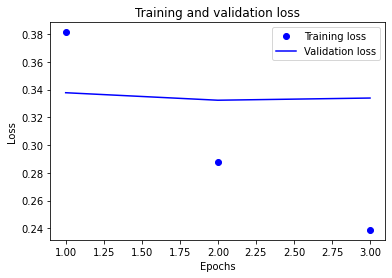

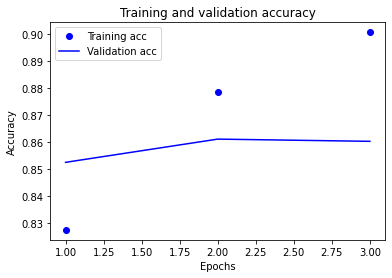

In [13]:
visualization(lstm_history)

#### 02.2.2 Conv1D

In [14]:
conv1d_history = fitting_machine(conv1d_model, 3)

Epoch 1/3
2741/2741 [==============================] - 17s 5ms/step - loss: 0.3796 - accuracy: 0.8252 - val_loss: 0.3332 - val_accuracy: 0.8531
Epoch 2/3
2741/2741 [==============================] - 15s 5ms/step - loss: 0.2610 - accuracy: 0.8922 - val_loss: 0.3302 - val_accuracy: 0.8584
Epoch 3/3
2741/2741 [==============================] - 15s 5ms/step - loss: 0.1686 - accuracy: 0.9353 - val_loss: 0.3913 - val_accuracy: 0.8504
1537/1537 - 3s - loss: 0.4005 - accuracy: 0.8463

This is conv1d_model
Loss: 0.40048927068710327
Accurancy: 0.8462680578231812



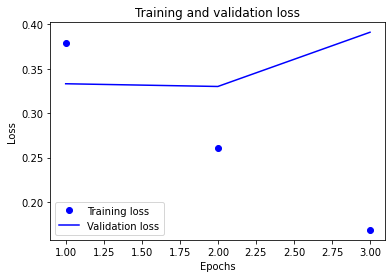

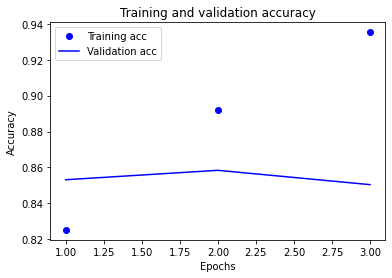

In [15]:
visualization(conv1d_history)

#### 02.2.3 GMP

In [16]:
gmp_history = fitting_machine(gmp_model, 5)

Epoch 1/5
2741/2741 [==============================] - 11s 4ms/step - loss: 0.4046 - accuracy: 0.8191 - val_loss: 0.3551 - val_accuracy: 0.8438
Epoch 2/5
2741/2741 [==============================] - 10s 4ms/step - loss: 0.3023 - accuracy: 0.8724 - val_loss: 0.3497 - val_accuracy: 0.8500
Epoch 3/5
2741/2741 [==============================] - 10s 4ms/step - loss: 0.2529 - accuracy: 0.8980 - val_loss: 0.3661 - val_accuracy: 0.8463
Epoch 4/5
2741/2741 [==============================] - 10s 4ms/step - loss: 0.2111 - accuracy: 0.9177 - val_loss: 0.3911 - val_accuracy: 0.8437
Epoch 5/5
2741/2741 [==============================] - 10s 4ms/step - loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.4299 - val_accuracy: 0.8400
1537/1537 - 2s - loss: 0.4322 - accuracy: 0.8397

This is gmp_model
Loss: 0.4322095215320587
Accurancy: 0.8396565914154053



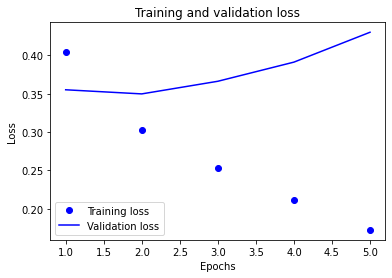

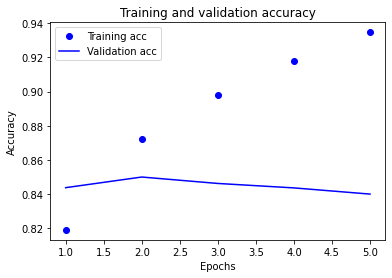

In [17]:
visualization(gmp_history)

## 03. Model embeding layer

### 03.1 lstm emdeding layer

In [18]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.06797565,  0.1355837 ,  0.1373755 , -0.0630826 , -0.10403558,
       -0.08027282,  0.10743004,  0.00170233, -0.01438868,  0.06628199,
       -0.00867042, -0.03376878, -0.02930173, -0.04660742,  0.05128373,
       -0.14103043, -0.1298416 ,  0.09679523, -0.02863735, -0.21662757,
        0.0066854 , -0.17381775, -0.04172801,  0.03355502, -0.08239   ,
       -0.13784271,  0.02807988, -0.0979026 , -0.05319535,  0.07188458,
       -0.11463896, -0.04215635,  0.01886554, -0.16521208, -0.07306395,
       -0.01160732, -0.10554281, -0.02493268,  0.10837907,  0.07913797,
       -0.02354291, -0.1469421 ,  0.03386083,  0.00866006,  0.02144554,
        0.03747693,  0.0427036 ,  0.05049077,  0.06347983,  0.0613207 ,
        0.07980196,  0.1096382 ,  0.10691079,  0.10547383,  0.1738668 ,
       -0.01089285,  0.00314148, -0.07662689, -0.08253678, -0.03843961,
        0.0043464 ,  0.02111812,  0.09782407,  0.08846591,  0.12412284,
        0.10147944,  0.0393299 ,  0.0171389 ,  0.03475457, -0.03

In [19]:
# lstm model을 통하여 만든 vector "감동"과 비슷한 단어들
word_vectors.similar_by_word("감동")

[('아름다운', 0.9411205649375916),
 ('압도', 0.94080650806427),
 ('보석', 0.9339301586151123),
 ('이뻐', 0.9338570833206177),
 ('찰리', 0.9311522245407104),
 ('잘생김', 0.9287165999412537),
 ('손색없', 0.9262828826904297),
 ('열린', 0.9200053215026855),
 ('입감', 0.9197369813919067),
 ('펑펑', 0.9192264080047607)]

In [20]:
# lstm model을 통하여 만든 vector "실망"과 비슷한 단어들
word_vectors.similar_by_word("실망")

[('가짜', 0.9651846289634705),
 ('쓰레기', 0.9600820541381836),
 ('OOO', 0.9538226127624512),
 ('용가리', 0.9513728618621826),
 ('빈약', 0.9478206634521484),
 ('재미없', 0.9470405578613281),
 ('잤', 0.946316659450531),
 ('혈압', 0.9441273212432861),
 ('졸작', 0.9428030848503113),
 ('지루', 0.9426817893981934)]

### 03.2 Conv1D emdeding layer

In [21]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 2.53127906e-02, -1.29544931e-02,  3.82216126e-02,  1.02612786e-01,
        2.72610188e-01, -1.35011047e-01, -1.11595057e-01, -1.84603706e-01,
       -1.81866631e-01,  1.45925744e-03,  5.57811335e-02,  4.45589162e-02,
       -1.33474357e-02,  1.02432156e-02, -1.68451592e-02, -6.19907938e-02,
        2.01605503e-02, -1.17447563e-01,  9.49516520e-02,  5.41615970e-02,
       -8.46147463e-02, -1.35803491e-01,  3.66551876e-02, -3.68126258e-02,
        7.93410987e-02,  8.95052031e-02, -2.19200611e-01,  1.09099492e-01,
       -1.08042136e-01,  1.83441415e-01, -7.85517599e-03, -1.03686951e-01,
        8.06799978e-02, -1.43688787e-02,  4.66370471e-02,  1.67482585e-01,
        9.62320268e-02,  8.52655806e-03, -3.35952733e-03,  1.96931455e-02,
       -1.42820641e-01, -2.11454600e-01, -4.00304198e-02, -2.94909477e-02,
       -1.45919636e-01,  4.98866551e-02,  8.05891976e-02,  5.22551200e-05,
        8.71910676e-02,  1.44452965e-02,  1.83373094e-02, -8.15625675e-03,
        3.52216586e-02, -

In [22]:
# conv1d model을 통하여 만든 vector "감동"과 비슷한 단어들
word_vectors.similar_by_word("감동")

[('롤러코스터', 0.8297891020774841),
 ('놀라웠', 0.817345917224884),
 ('주옥같', 0.810905933380127),
 ('편안', 0.810460090637207),
 ('완소', 0.8093061447143555),
 ('젬', 0.8086325526237488),
 ('앓', 0.8067060112953186),
 ('클레이', 0.8053863048553467),
 ('예뻐요', 0.8011735081672668),
 ('기막힌', 0.8000566363334656)]

In [23]:
# conv1d model을 통하여 만든 vector "실망"과 비슷한 단어들
word_vectors.similar_by_word("실망")

[('자질', 0.888278603553772),
 ('챙피', 0.8839362859725952),
 ('빈약', 0.8797338008880615),
 ('뻔했', 0.8767226934432983),
 ('결여', 0.8699007034301758),
 ('퉤', 0.8690875172615051),
 ('실패작', 0.8689863681793213),
 ('낭비', 0.8688830137252808),
 ('역겨웠', 0.8615521192550659),
 ('별론데', 0.8607015609741211)]

### 03.3 GMP emdeding layer

In [24]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector


array([-0.14366952, -0.04783695, -0.04839371,  0.0094797 ,  0.01584284,
       -0.11096233, -0.04838162, -0.03335236,  0.03941106, -0.01698603,
       -0.07707217,  0.02250049, -0.09203346, -0.08635528, -0.12535031,
       -0.00212872,  0.01902799,  0.12445839, -0.10997654, -0.12963858,
        0.20910363, -0.11305529, -0.0663897 ,  0.03579544, -0.11307922,
       -0.09512287, -0.07588945, -0.15677492, -0.09099009, -0.07499539,
       -0.0129795 , -0.1347505 , -0.12361696, -0.09136647, -0.04936582,
       -0.00957945,  0.20741576, -0.06414691, -0.00325607, -0.0314059 ,
        0.0310864 ,  0.11892456,  0.04854522, -0.09818767, -0.09289701,
       -0.10237363, -0.06249695,  0.07519243, -0.07104953, -0.05588046,
        0.07663175, -0.09111308, -0.11253771, -0.10190626, -0.03399803,
       -0.08466739, -0.09296577,  0.00848108, -0.0378561 , -0.01555244,
       -0.07459715, -0.0120921 , -0.02423434, -0.03285239], dtype=float32)

In [25]:
# gmp model을 통하여 만든 vector "감동"과 비슷한 단어들
word_vectors.similar_by_word("감동")

[('퀄리티', 0.7456117272377014),
 ('역시', 0.7106660604476929),
 ('~~', 0.7031740546226501),
 ('르네', 0.6987693309783936),
 ('자주', 0.6959245204925537),
 ('어마어마', 0.692947506904602),
 ('펭귄', 0.6916792988777161),
 ('슬퍼', 0.6883925199508667),
 ('반담', 0.683761715888977),
 ('그리운', 0.6829804182052612)]

In [26]:
# gmp model을 통하여 만든 vector "실망"과 비슷한 단어들
word_vectors.similar_by_word("실망")

[('따분', 0.7970080375671387),
 ('별로', 0.79494309425354),
 ('히히', 0.7945777177810669),
 ('..............', 0.7915064692497253),
 ('벗', 0.7818416357040405),
 ('OOO', 0.777866780757904),
 ('지겹', 0.7757134437561035),
 ('뻔해', 0.7747142910957336),
 ('특촬물', 0.7738757133483887),
 ('맞췄', 0.7729415893554688)]

## 04. 한국어 Word2Vec

### 04.1 한국어 Word2Vec loading

In [27]:
'''
gensim 사용을 위하여 버전을 낮춰야함.
'''
#pip install gensim==3.8.1
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [28]:
word2vec.similar_by_word("감동")

[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [29]:
word2vec.similar_by_word("실망")

[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

In [30]:
# model에 사용할 embedding layer 만들기
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 04.2 Model wiht 한국어 Word2Vec

In [31]:
'''
subclassing을 활용하여
lstm, conv1d, gmp model과 한국어 word2vec을 embedding하는 model을 만든다.
'''

class LSTMModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.lstm = keras.layers.LSTM(64)
        self.dense1 = keras.layers.Dense(256, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class Conv1DModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.conv1 = keras.layers.Conv1D(64, 7, activation='relu')
        self.maxp = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(64, 7, activation='relu')
        self.gmaxp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.gmaxp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

class GMPModel_ko(keras.Model):
    def __init__(self,embedding_m):
        super().__init__()
        vocab_size = 10000
        word_vector_dim = 200
        
        self.embedding = keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_m),
                                 input_length=maxlen, 
                                 trainable=True)
        self.gmp = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.gmp(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return x

In [32]:
# model 선언
lstm_model_ko = LSTMModel_ko(embedding_matrix)
conv1d_model_ko = Conv1DModel_ko(embedding_matrix)
gmp_model_ko = GMPModel_ko(embedding_matrix)

### 04.3 Model Train & Evaluate with 한국어 Word2Vec

#### 04.3.1 lstm with 한국어 Word2Vec

In [33]:
lstm_ko_history = fitting_machine(lstm_model_ko, 3)

Epoch 1/3
2741/2741 [==============================] - 19s 7ms/step - loss: 0.4027 - accuracy: 0.8144 - val_loss: 0.3396 - val_accuracy: 0.8511
Epoch 2/3
2741/2741 [==============================] - 18s 6ms/step - loss: 0.3001 - accuracy: 0.8725 - val_loss: 0.3251 - val_accuracy: 0.8593
Epoch 3/3
2741/2741 [==============================] - 18s 6ms/step - loss: 0.2542 - accuracy: 0.8937 - val_loss: 0.3297 - val_accuracy: 0.8595
1537/1537 - 3s - loss: 0.3341 - accuracy: 0.8575

This is lstm_model_ko
Loss: 0.33407068252563477
Accurancy: 0.857477068901062



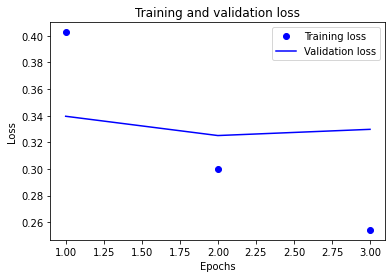

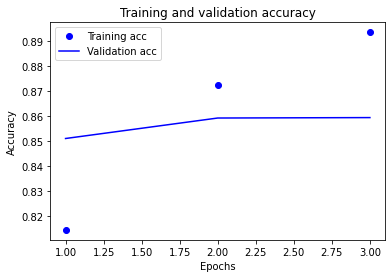

In [34]:
visualization(lstm_ko_history)

#### 04.3.2 conv1d with 한국어 Word2Vec

In [35]:
conv1d_ko_history = fitting_machine(conv1d_model_ko, 2)

Epoch 1/2
2741/2741 [==============================] - 17s 6ms/step - loss: 0.4416 - accuracy: 0.7875 - val_loss: 0.3809 - val_accuracy: 0.8323
Epoch 2/2
2741/2741 [==============================] - 16s 6ms/step - loss: 0.3185 - accuracy: 0.8625 - val_loss: 0.3559 - val_accuracy: 0.8437
1537/1537 - 3s - loss: 0.3594 - accuracy: 0.8415

This is conv1d_model_ko
Loss: 0.359407901763916
Accurancy: 0.841487467288971



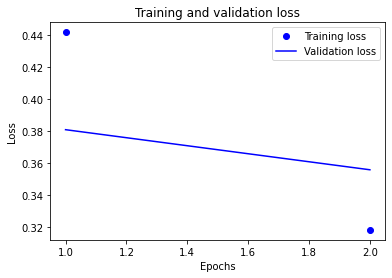

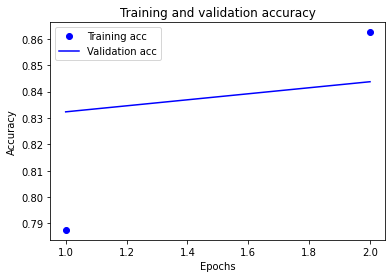

In [36]:
visualization(conv1d_ko_history)

#### 04.3.3  GMP with 한국어 Word2Vec

In [37]:
gmp_ko_history = fitting_machine(gmp_model_ko, 6)

Epoch 1/6
2741/2741 [==============================] - 12s 4ms/step - loss: 0.5980 - accuracy: 0.6837 - val_loss: 0.5034 - val_accuracy: 0.7689
Epoch 2/6
2741/2741 [==============================] - 11s 4ms/step - loss: 0.4536 - accuracy: 0.7965 - val_loss: 0.4367 - val_accuracy: 0.8005
Epoch 3/6
2741/2741 [==============================] - 11s 4ms/step - loss: 0.3896 - accuracy: 0.8304 - val_loss: 0.4109 - val_accuracy: 0.8152
Epoch 4/6
2741/2741 [==============================] - 11s 4ms/step - loss: 0.3494 - accuracy: 0.8517 - val_loss: 0.4121 - val_accuracy: 0.8129
Epoch 5/6
2741/2741 [==============================] - 11s 4ms/step - loss: 0.3194 - accuracy: 0.8674 - val_loss: 0.3972 - val_accuracy: 0.8247
Epoch 6/6
2741/2741 [==============================] - 11s 4ms/step - loss: 0.2910 - accuracy: 0.8816 - val_loss: 0.4031 - val_accuracy: 0.8263
1537/1537 - 2s - loss: 0.4077 - accuracy: 0.8248

This is gmp_model_ko
Loss: 0.4076833724975586
Accurancy: 0.8247655630111694



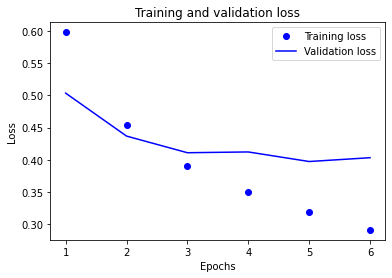

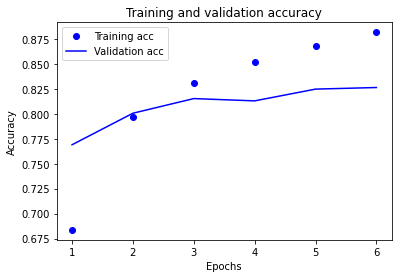

In [38]:
visualization(gmp_ko_history)

## 05. 회고

> 1. Gensim issue version
    - 한국어word2vec를 사용하기위하여 많은 error가 있었다. version 문제가 있었다. version관리는 핵심이다. gensim 사용을 위하여 버전을 낮춰야한다.
> 2. Early stop issue
    - model을 Subclass로 생성하면 Early stop이 되지 않는다. error에는 memory 문제가 있다고 한다. early stop을 꼭 써야한다면 Subclass 말고 Functional이나 Sequential을 활용해야한다.
> 3. Parameter, dimension 크기 조절이 잘 모르겠음.
    - vocab의 size, dimension의 크기, model을 생성할 때 layer에 넣는 숫자를 어떻게 넣어야할지 감이 잘 안잡힌다. 직감적으로 이해가 되지는 않아 인터넷을 참고하여 parameter를 결정하였다. paratmeter를 자유자재로 설정하고 싶다.
> 4. epoch
    - epoch값이 조금만 커져도 val_loss가 심하게 바뀐다. overfitting이 쉽게 나는 것을 확인할 수 있었다. data가 적어서 생기는 문제인지 model이 가지고 있는 문제인지는 잘 모르겠다.
> 5. NLP
    - NLP 아직까지는 잘 모르겠지만 조금은 익숙해진다. embedding layer를 이용하고 token화 시켜주고 혼자서 하지는 못하겠지만 나중에 혼자서도 전처리할 수 있는 도전을 해보고 싶다. 신기하다.